In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import seaborn as sns
import datetime
from group_lasso import GroupLasso
from sklearn.utils import resample, check_random_state
from sklearn.model_selection import cross_val_score, cross_validate

from extra_functions import *

# Silence some warnings
import warnings
warnings.filterwarnings('ignore')

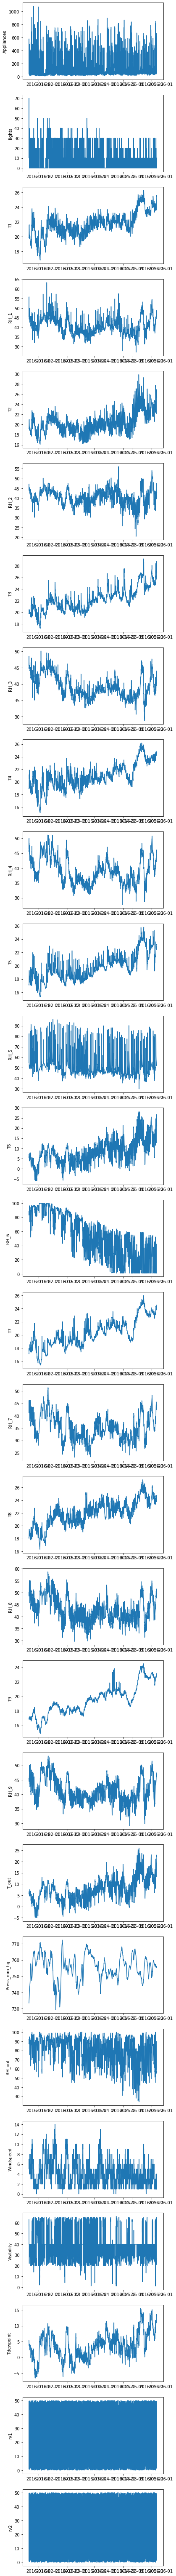

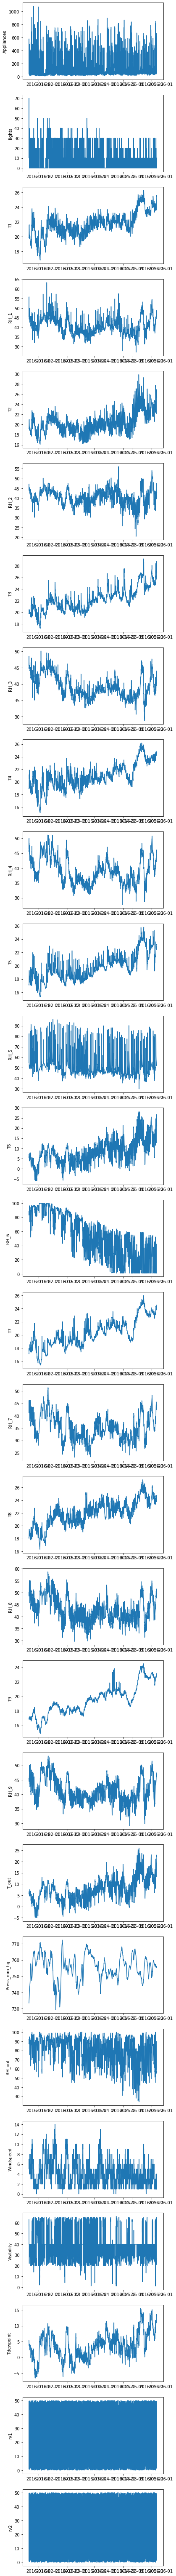

In [2]:
df = pd.read_csv('energydata_complete.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

fig = plot_data(df)
fig

### Taking an 24-hour mean

In [3]:
df = df.resample('24h').mean()

### Generating extra features to describe time
weekday: number [0,6]\
weekstatus: binary describing weekend (1) or not (0)\
NSM: Number of Seconds from Midnight

These are used for filtering the data

In [4]:
weekday = np.zeros(len(df))
weekstatus = np.zeros(len(df))
NSM = np.zeros(len(df))
month = np.zeros(len(df))

for i, val in enumerate(df.index):
    weekday[i] = val.weekday()
    weekstatus[i] = (weekday[i] >= 5)  # False for workday, True for weekend
    NSM[i] = (val - val.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    month[i] = val.month

df['weekday'] = weekday
df['week status'] = weekstatus
df['NSM'] = NSM
df['month'] = month

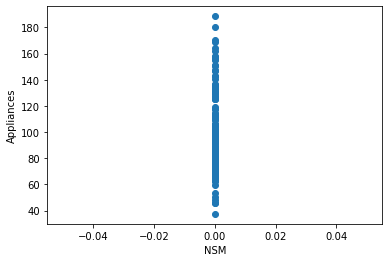

In [5]:
plt.figure()
plt.scatter(df['NSM'],df['Appliances'])
plt.xlabel('NSM')
plt.ylabel('Appliances')
plt.show()

### Filtering data and making training set
Example: Only february, after 16:00 and workday

In [6]:
df_train = df[(df.index.month==2)]
# dropping the features used for filtering
df_train = df_train.drop(['weekday', 'week status','month','NSM'], axis=1) 

# Training data
y = np.array(df_train['Appliances']).reshape(-1,1)
X = np.array(df_train[df_train.columns[1:]])
X, y = standardize(X,y)

### Correlations of covariates

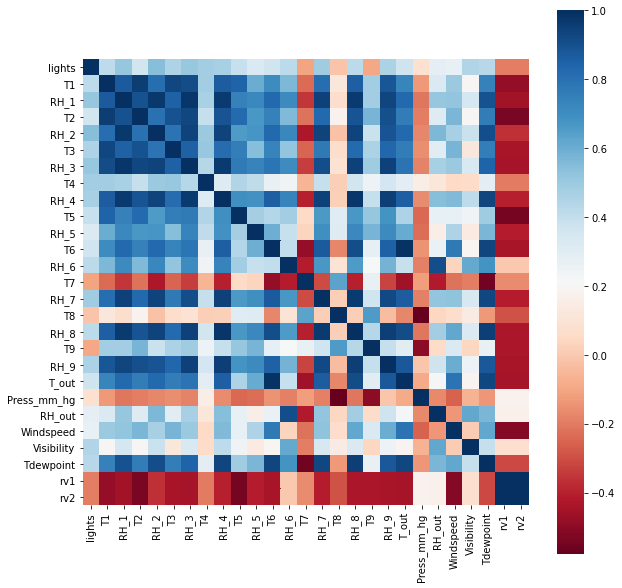

In [7]:
cor = df_train[df_train.columns[1:]].corr()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(cor, square=True, xticklabels=True, yticklabels=True, cmap='RdBu')
plt.show()

### Cross validation

In [8]:
# Creating array of penalties

n_alpha = 100 # Number of penalties
min_alpha = .01 # min penalty
max_alpha = 200 # Maximum penalty
alpha_vals = np.logspace(np.log10(min_alpha),np.log10(max_alpha),n_alpha)
alpha_vals = alpha_vals[::-1] # reversing array (some sklearn standard?)

#### CV Lasso

In [9]:
cv_lasso = linear_model.LassoCV(cv=10, random_state=0, fit_intercept=False, alphas=alpha_vals).fit(X, y)

#### CV Ridge

In [10]:
cv_ridge = linear_model.ElasticNetCV(cv=10, random_state=0, l1_ratio=0, fit_intercept=False, alphas=alpha_vals).fit(X, y)

#### CV Elastic net (0.5 ratio)

In [11]:
cv_elnet = linear_model.ElasticNetCV(cv=10, random_state=0, l1_ratio=0.5, fit_intercept=False, alphas=alpha_vals).fit(X, y)

In [12]:
print('Lasso score: ', cv_lasso.score(X,y))
print('Ridge score: ', cv_ridge.score(X,y))
print('Elastic net score: ', cv_elnet.score(X,y))

Lasso score:  0.6421888356852423
Ridge score:  0.5818720376615034
Elastic net score:  0.5165705184061405


Optimal value of lambda is: 0.668
Optimal value of lambda is: 0.135
Optimal value of lambda is: 0.405


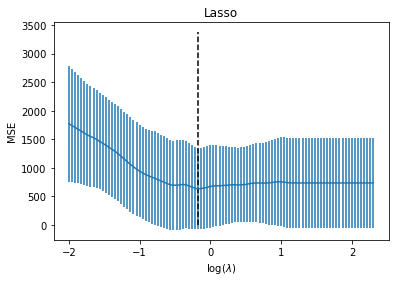

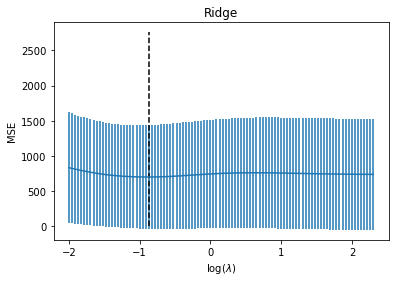

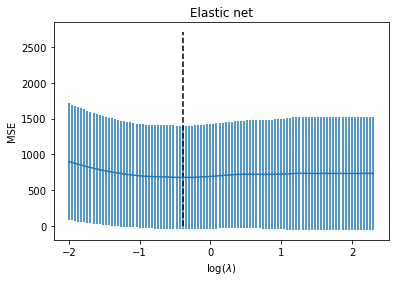

In [13]:
plot_CV_MSE(alpha_vals,cv_lasso.mse_path_,cv_lasso.alpha_, 'Lasso')
plot_CV_MSE(alpha_vals,cv_ridge.mse_path_,cv_ridge.alpha_, 'Ridge')
plot_CV_MSE(alpha_vals,cv_elnet.mse_path_,cv_elnet.alpha_, 'Elastic net');

### Cross validation parameters

In [14]:
# Creating array of penalties
n_alpha = 100 # Number of penalties
min_alpha = .01 # min penalty
max_alpha = 200 # Maximum penalty
alpha_vals = np.logspace(np.log10(min_alpha),np.log10(max_alpha),n_alpha)
alpha_vals = alpha_vals[::-1] # reversing array (some sklearn standard?)

### Ordinary least squares

In [15]:
reg_lstsq = linear_model.LinearRegression(fit_intercept=False)
beta_ls = reg_lstsq.fit(X,y).coef_

### Lasso

In [16]:
reg = linear_model.Lasso(max_iter = 10000, fit_intercept = False)
beta_lasso, best_beta_lasso, cv_out_lasso, min_alpha_lasso = feature_selection_cv(X, y, alpha_vals, reg)
    
# Best model   
reg_lasso = linear_model.Lasso(alpha=min_alpha_lasso, max_iter = 10000, fit_intercept = False)

### Ridge

In [17]:
reg = linear_model.ElasticNet(max_iter = 10000, l1_ratio=0, fit_intercept = False)

beta_ridge, best_beta_ridge, cv_out_ridge, min_alpha_ridge = feature_selection_cv(X, y, alpha_vals, reg)
        
# Best model
reg_ridge = linear_model.ElasticNet(alpha=min_alpha_ridge, max_iter = 10000, l1_ratio=0.0, fit_intercept = False)

### Elastic net

In [18]:
reg = linear_model.ElasticNet(max_iter = 10000, l1_ratio=0.5, fit_intercept = False)
beta_elnet, best_beta_elnet, cv_out_elnet, min_alpha_elnet = feature_selection_cv(X, y, alpha_vals, reg)

# Best model
reg_elnet = linear_model.ElasticNet(alpha=min_alpha_elnet, max_iter = 10000, l1_ratio=0.5, fit_intercept = False)

### Group lasso

In [19]:
group_keys= {"T":1,
            "RH":2,
            "":-1}

groups = []

# Loop over all the variables names and group them to the first match out of "T", "RH", and "" (any string)
for var_name in df_train.columns[1:]:
    for key, value in group_keys.items():
        if key in var_name:
            groups.append(value)
            break

            # Print which variable ended up in which group
print(*zip(groups, df_train.columns[1:]))

reg = GroupLasso(groups=groups, frobenius_lipschitz=True, subsampling_scheme=1,
                 fit_intercept=False, random_state=0, supress_warning=True, n_iter=10000, tol=0.0001,
    )
group_reg = 0.05
beta_glasso, best_beta_glasso, cv_out_glasso, min_alpha_glasso = feature_selection_cv(X, y, alpha_vals, reg, 
                                                                                      group_reg=group_reg)

(-1, 'lights') (1, 'T1') (2, 'RH_1') (1, 'T2') (2, 'RH_2') (1, 'T3') (2, 'RH_3') (1, 'T4') (2, 'RH_4') (1, 'T5') (2, 'RH_5') (1, 'T6') (2, 'RH_6') (1, 'T7') (2, 'RH_7') (1, 'T8') (2, 'RH_8') (1, 'T9') (2, 'RH_9') (1, 'T_out') (-1, 'Press_mm_hg') (2, 'RH_out') (-1, 'Windspeed') (-1, 'Visibility') (1, 'Tdewpoint') (-1, 'rv1') (-1, 'rv2')


In [20]:
# Best model
reg_gl = GroupLasso(
    groups=groups,
    group_reg=group_reg*min_alpha_glasso,
    l1_reg=(1-group_reg)*min_alpha_glasso,
    frobenius_lipschitz=True,
    subsampling_scheme=1,
    fit_intercept=False,
    random_state=0,
    supress_warning=True,
    n_iter=10000,
    tol=0.0001,
    )

### Plotting coefficients vs lambda

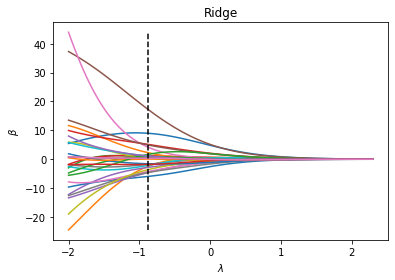

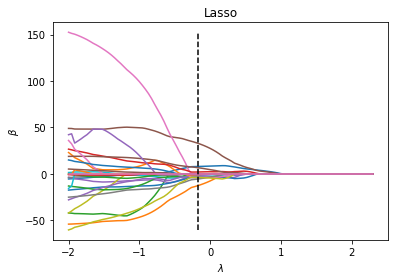

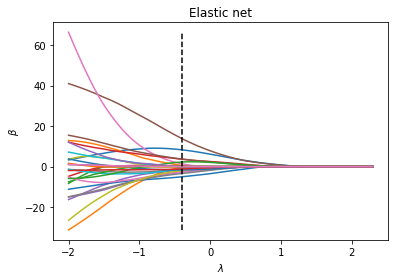

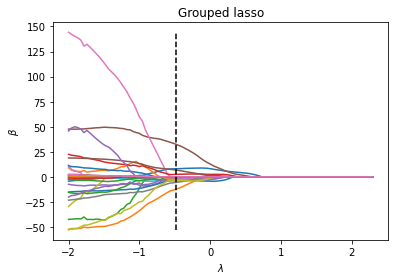

In [21]:
plot_coefficients(beta_ridge, alpha_vals, min_alpha_ridge, name='Ridge')
plot_coefficients(beta_lasso, alpha_vals, min_alpha_lasso, name='Lasso')
plot_coefficients(beta_elnet, alpha_vals, min_alpha_elnet, name='Elastic net')
plot_coefficients(beta_glasso, alpha_vals, min_alpha_glasso, name='Grouped lasso');

Optimal value of lambda is: 0.135
Optimal value of lambda is: 0.668
Optimal value of lambda is: 0.405
Optimal value of lambda is: 0.332


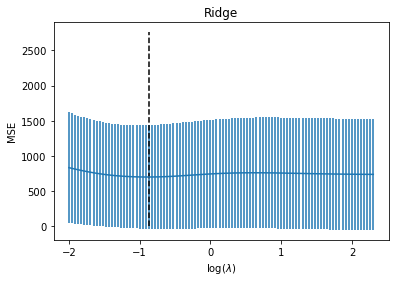

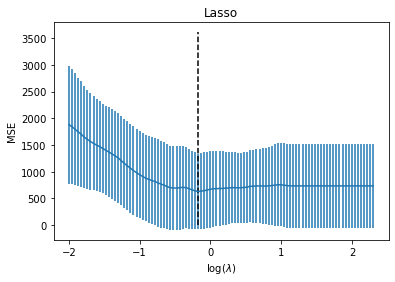

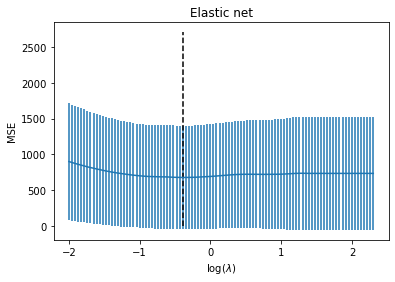

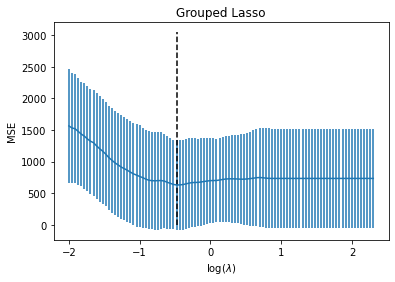

In [22]:
plot_CV_MSE(alpha_vals, -np.array(cv_out_ridge), min_alpha_ridge, 'Ridge')
plot_CV_MSE(alpha_vals, -np.array(cv_out_lasso), min_alpha_lasso, 'Lasso')
plot_CV_MSE(alpha_vals, -np.array(cv_out_elnet), min_alpha_elnet, 'Elastic net')
plot_CV_MSE(alpha_vals, -np.array(cv_out_glasso), min_alpha_glasso, 'Grouped Lasso');

In [23]:
data = {'Feature': list(df_train.columns[1:])}
df_results = pd.DataFrame(data)
df_results['Least squares'] = beta_ls.T
df_results['Lasso'] = beta_lasso[:,alpha_vals==min_alpha_lasso]
df_results['Ridge'] = beta_ridge[:,alpha_vals==min_alpha_ridge]
df_results['Elastic net'] = beta_elnet[:,alpha_vals==min_alpha_elnet]
df_results['Group Lasso'] = beta_glasso[:,alpha_vals==min_alpha_glasso]
df_results

,Feature,Least squares,Lasso,Ridge,Elastic net,Group Lasso
0,lights,-5.776120,8.028958,8.971135,8.278968,8.124382
1,T1,-145.822612,-12.625089,-2.438151,-0.249461,-12.217616
2,RH_1,-217.986139,-0.000000,0.539393,0.000000,-0.000000
3,T2,157.204266,-0.000000,1.190867,0.099541,-0.000000
4,RH_2,227.277307,-2.011784,-2.807654,-1.712471,-1.850258
5,T3,94.467122,33.073335,17.146150,13.745645,32.460911
6,RH_3,116.414617,0.000000,4.091209,1.354249,0.000000
7,T4,-30.643890,-3.886322,-1.752233,-1.238466,-3.774165
8,RH_4,-103.788047,-0.000000,0.312254,-0.000000,-0.000000
9,T5,-27.882443,-0.626653,-2.098688,-1.075874,-0.925207


In [24]:
regs = [reg_lstsq,reg_ridge,reg_lasso,reg_elnet,reg_gl]
labels = ['Least squares','Ridge','Lasso','Elastic net','Group lasso']

#Also get the cross-validation score for the least-squares
cv_ls = cross_val_score(reg_lstsq, X, y, cv=10,
                                 scoring='neg_mean_squared_error')
meanMSE = [-cv_ls.mean(),
    np.min(-np.array(cv_out_lasso).mean(axis=1)),
    np.min(-np.array(cv_out_ridge).mean(axis=1)),
    np.min(-np.array(cv_out_elnet).mean(axis=1)),
    np.min(-np.array(cv_out_glasso).mean(axis=1))
          ]

train_scores = []
for reg in regs:
    reg.fit(X,y)
    train_scores.append(reg.score(X,y))
    
Errors_table = pd.DataFrame()
Errors_table['Model'] = ['Least squares','Ridge','Lasso','Elastic net','Group lasso']
Errors_table['Train scores'] = np.round(train_scores, 3)
Errors_table['Mean MSE'] = np.round(meanMSE, 1)
Errors_table

,Model,Train scores,Mean MSE
0,Least squares,0.963,18965.6
1,Ridge,0.582,630.3
2,Lasso,0.642,699.3
3,Elastic net,0.517,677.7
4,Group lasso,0.641,630.6


### Testing with another month

Train score, Least squares:  0.963
Test score: Least squares:  -207.863
Train score, Ridge:  0.582
Test score: Ridge:  0.109
Train score, Lasso:  0.642
Test score: Lasso:  0.254
Train score, Elastic net:  0.517
Test score: Elastic net:  0.125
Train score, Group lasso:  0.641
Test score: Group lasso:  0.254


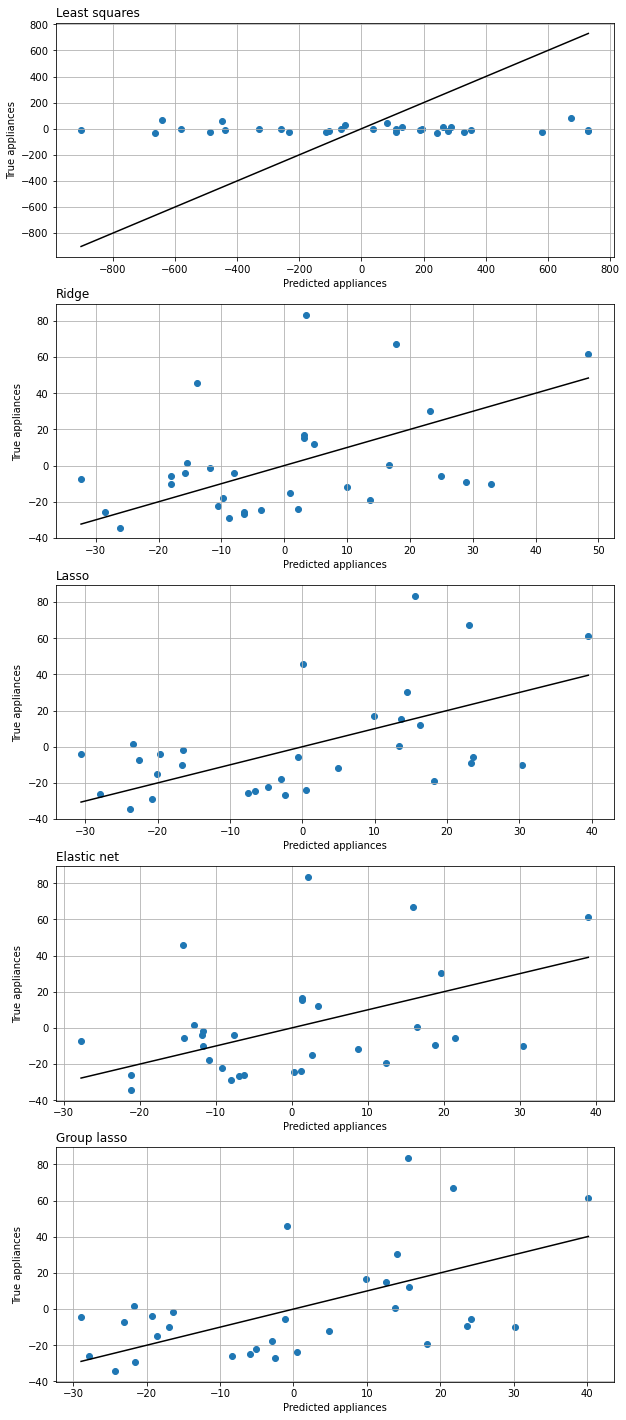

In [25]:
months = [3]
regs = [reg_lstsq,reg_ridge,reg_lasso,reg_elnet,reg_gl]
labels = ['Least squares','Ridge','Lasso','Elastic net','Group lasso']

fig, axs = plt.subplots(len(regs))
fig.set_figheight(25)
fig.set_figwidth(10)

df_test = df[np.isin(df.index.month,months)]
df_test = df_test.drop(['weekday', 'week status','month','NSM'], axis=1) # dropping the features used for filtering

y_t = np.array(df_test['Appliances']).reshape(-1,1)
X_t = np.array(df_test[df_test.columns[1:]])

i = 0
for reg in regs:
    # Testing data
    X_t, y_t = standardize(X_t,y_t)
    reg.fit(X,y)
    y_p = reg.predict(X_t)
    axs[i].plot([min(y_p),max(y_p)],[min(y_p),max(y_p)],'k-')
    axs[i].scatter(reg.predict(X_t),y_t)
    axs[i].grid()
    axs[i].set_title(labels[i], loc='left')
    print('Train score, '+labels[i]+': ',np.round(reg.score(X,y),3))
    print('Test score: '+labels[i]+': ',np.round(reg.score(X_t,y_t),3))
    i+=1
    
for ax in axs.flat:
    ax.set(xlabel='Predicted appliances', ylabel='True appliances')
    
plt.show()

### Bootstrap CV

In [26]:
%%time
# The code in the rest of this notebook scales with this number
# We ran with len(df_train) samples, but you probably want to 
# change this to something more managable
boot_samples = len(df_train) #1
boot_size = len(df_train)

reg_lasso = linear_model.Lasso(max_iter=10000, fit_intercept=False)
betas_lasso = bootstrap_loop(X, y, alpha_vals, reg_lasso, b=boot_size, N_samples=boot_samples)

CPU times: user 2min 29s, sys: 45 ms, total: 2min 29s
Wall time: 2min 29s


In [27]:
%%time
reg_ridge = linear_model.ElasticNet(alpha=min_alpha_ridge, max_iter = 10000, l1_ratio=0.0, fit_intercept = False)
betas_ridge = bootstrap_loop(X, y, alpha_vals, reg_ridge, b=boot_size, N_samples=boot_samples)

CPU times: user 13min 33s, sys: 92.4 ms, total: 13min 33s
Wall time: 13min 33s


In [28]:
%%time
reg_elnet = linear_model.ElasticNet(alpha=min_alpha_elnet, max_iter=10000, l1_ratio=0.5, fit_intercept = False)
betas_elnet = bootstrap_loop(X, y, alpha_vals, reg_elnet, b=boot_size, N_samples=boot_samples)

CPU times: user 1min 17s, sys: 43.9 ms, total: 1min 17s
Wall time: 1min 17s


In [29]:
%%time
reg_gl = reg_gl = GroupLasso(
    groups=groups,
    group_reg=group_reg*min_alpha_glasso,#alpha_vals[i],
    l1_reg=(1-group_reg)*min_alpha_glasso,
    frobenius_lipschitz=True,
    #scale_reg="inverse_group_size",
    #scale_reg="inverse_group_size",
    subsampling_scheme=1,
    fit_intercept=False,
    random_state=0,
    supress_warning=True,
    n_iter=10000,
    tol=0.0001,
    )
betas_gl = bootstrap_loop(X, y, alpha_vals, reg_gl, b=boot_size, N_samples=boot_samples, group_reg=group_reg)

CPU times: user 1h 31min 19s, sys: 45.4 s, total: 1h 32min 4s
Wall time: 1h 31min 12s


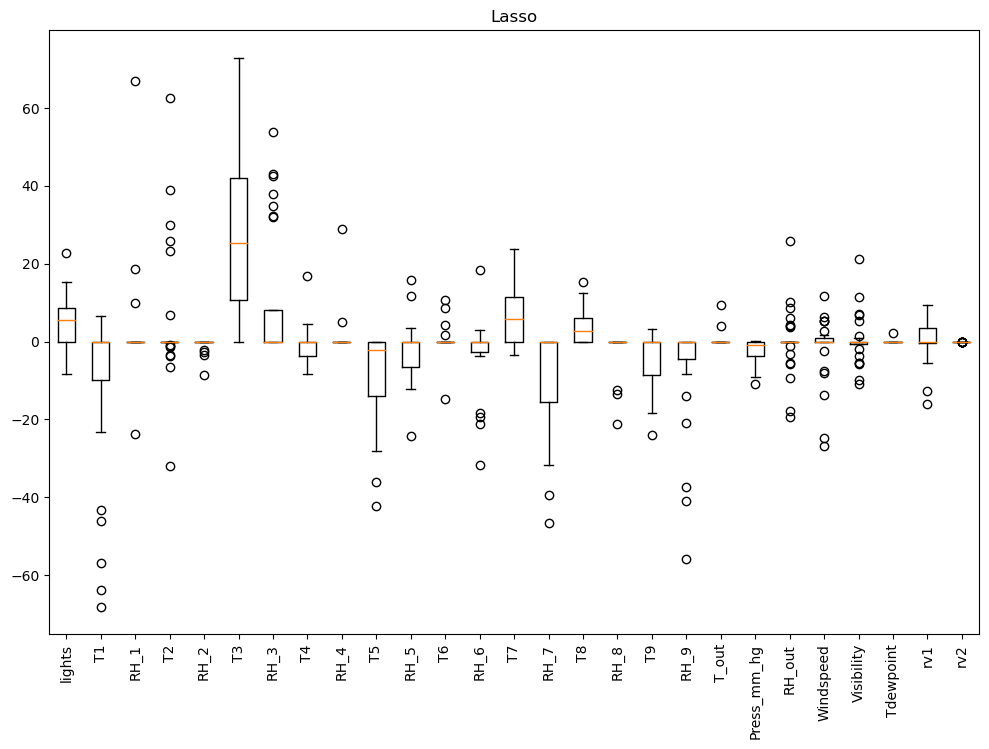

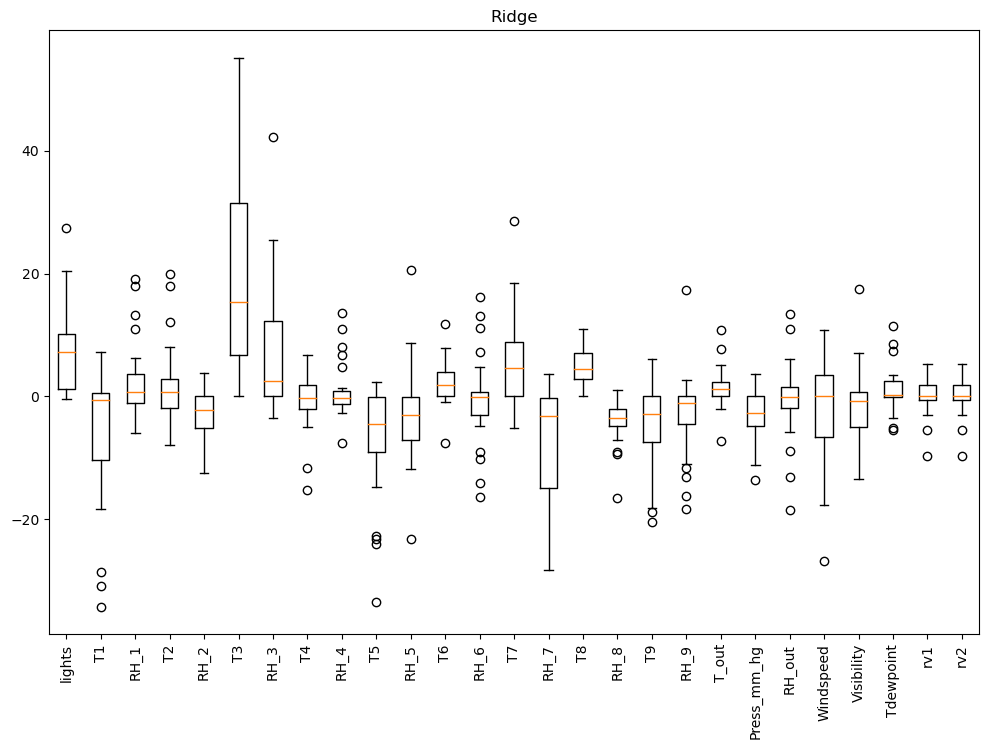

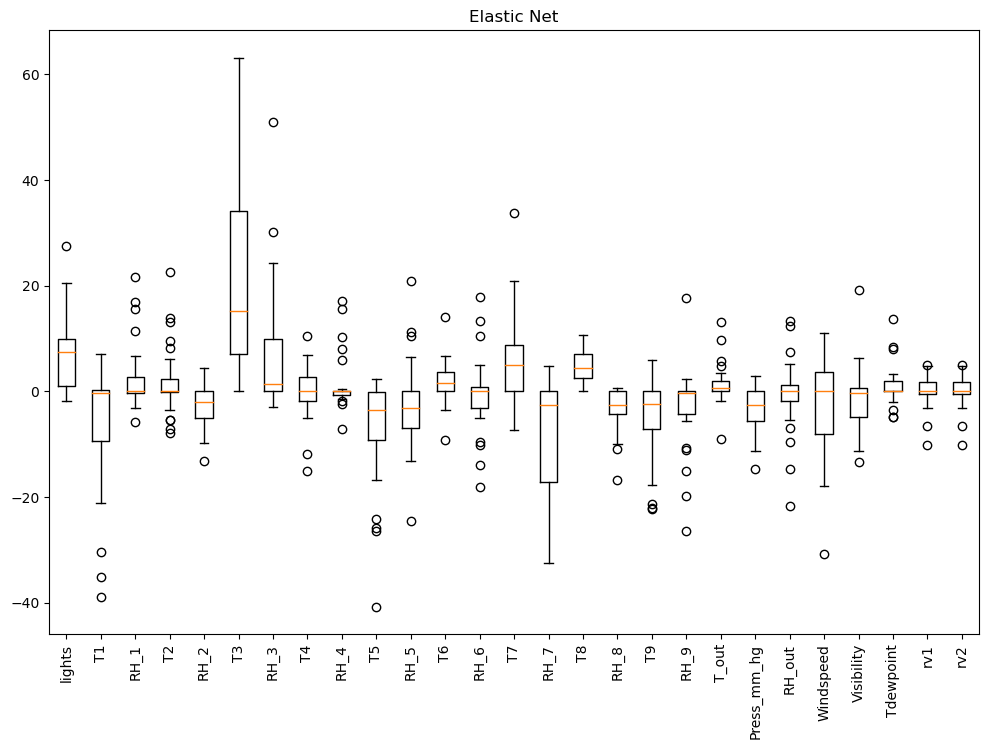

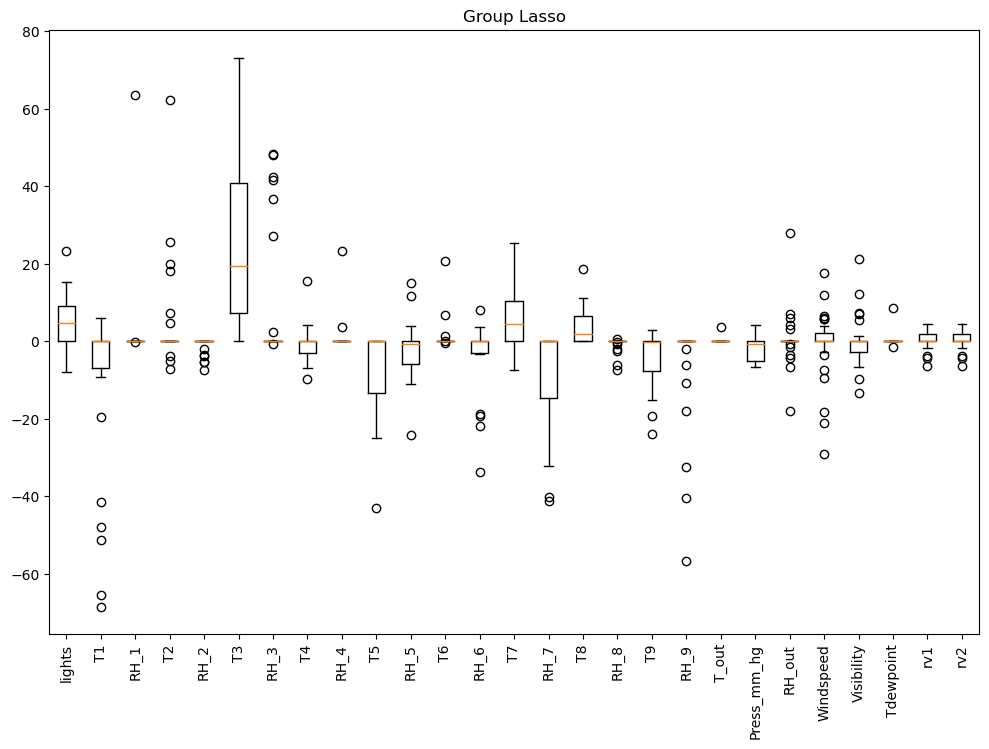

In [30]:
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.boxplot(betas_lasso,labels=df_train.columns[1:])
plt.xticks(rotation='vertical')
plt.title('Lasso')
plt.show()

plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.boxplot(betas_ridge,labels=df_train.columns[1:])
plt.xticks(rotation='vertical')
plt.title('Ridge')
plt.show()

plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.boxplot(betas_elnet,labels=df_train.columns[1:])
plt.xticks(rotation='vertical')
plt.title('Elastic Net')
plt.show()


plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.boxplot(betas_gl,labels=df_train.columns[1:])
plt.xticks(rotation='vertical')
plt.title('Group Lasso')
plt.show()


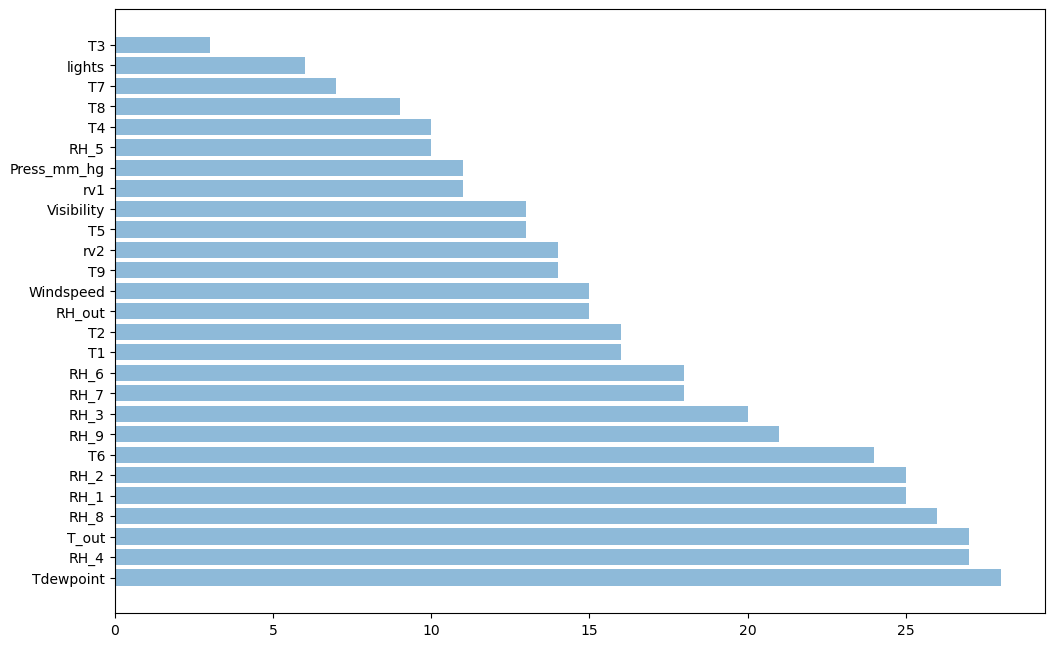

In [31]:
number_of_zeros = np.sum(betas_lasso == 0,axis=0)
y_pos = np.arange(len(df_train.columns[1:]))

# Sorting in descenting order
labels = df_train.columns[1:][number_of_zeros.argsort()][::-1]
number_of_zeros[::-1].sort()

plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.barh(y_pos,number_of_zeros ,align='center', alpha=0.5)
plt.yticks(y_pos, labels)
plt.show()